In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model

In [2]:
# Functions

def line(x, m, b):
    return x * m + b

def tlm(s, r_s, N, w, L, r_c):
    return ((r_s * s) / (2 * N * (w + L + s) - L - s)) + (2 * r_c)

def tlm2(s, r_s, N, w, L, l_t):
    return (r_s / (2 * N * (w + L + s) - L - s)) * (s + 2 * l_t)

def w_contact(s, N, w, L):
    return (2 * N * (w + L + s)) - L - s
    
idea2 = {'P01': 2e-4,
         'P02': 5e-4,
         'P03': 10e-4,
         'P04' : 20e-4
         }

In [3]:
# Models

line_mod = Model(line)
line_params = line_mod.make_params()
line_params['m'].set(value = 1)
line_params['b'].set(value = 1)

# Not considering L_t transfer lenght
tlm_mod = Model(tlm)
tlm_params = tlm_mod.make_params()
tlm_params['r_s'].set(value = 1e6)
tlm_params['N'].set(value = 60, vary = False)
tlm_params['w'].set(value = 5e-4, vary = False)
tlm_params['L'].set(value = 3200e-4, vary = False)
tlm_params['r_c'].set(value = 1)

# Considering L_t to get \rho_c Contact Resistivity
tlm_mod2 = Model(tlm2)
tlm2_params = tlm_mod2.make_params()
tlm2_params['r_s'].set(value = 1e6)
tlm2_params['N'].set(value = 60, vary = False)
tlm2_params['w'].set(value = 5e-4, vary = False)
tlm2_params['L'].set(value = 3200e-4, vary = False)
tlm2_params['l_t'].set(value = 1, min = 0)



In [17]:
# Function to process data

def C_R(path):
    
    files = [os.path.join(path, i) for i in os.listdir(path)]
    col = ['Potential (V)', 'Current (A)', 'Time (s)']
    col2 = ['Structure', 'Spacing (cm)', 'Resistance ($\Omega$)']
    iv_val = pd.DataFrame(columns = col2)

    n = 0
    for i in files:
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col)
        line_fit = line_mod.fit(df[col[1]], line_params, x = df[col[0]])
        resistance = 1 / line_fit.values['m']

        
        
        for j in idea2.keys():
            if j in i:
                iv_val.loc[n] = (j, idea2[j], resistance)
        n += 1

    width_ = (w_contact(iv_val[col2[1]], 60, 5e-4, 3200e-4))
    width_avg = width_.mean()

    # tlm_fit = tlm_mod.fit(iv_val[col2[2]], tlm_params, s = iv_val[col2[1]])
    # print(tlm_fit.fit_report())

    # # Plot
    # sns.scatterplot(data = iv_val, x = col2[1], y = col2[2])
    # plt.plot(iv_val[col2[1]], tlm_fit.best_fit)

    tlm_fit2 = tlm_mod2.fit(iv_val[col2[2]], tlm2_params, s = iv_val[col2[1]])
    print(tlm_fit2.fit_report())
    rc = tlm_mod2.eval(tlm_fit2.params, s = 0) / 2
    lt = tlm_fit2.values['l_t']
    p_c = rc * lt * width_avg #Contact resistiviy ohm * cm^2

    # Plot
    sns.scatterplot(data = iv_val, x = col2[1], y = col2[2], label = 'Data')
    plt.plot(iv_val[col2[1]], tlm_fit2.best_fit, 'tab:orange', label = 'Fit')
    plt.legend()
    # print(width_)
    print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')


[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 237
    # data points      = 15
    # variables        = 2
    chi-square         = 4.2272e+12
    reduced chi-square = 3.2517e+11
    Akaike info crit   = 399.467544
    Bayesian info crit = 400.883644
    R-squared          = 0.92836616
[[Variables]]
    r_s:  1.1387e+11 +/- 8.7456e+09 (7.68%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  7.4895e-05 +/- 4.5682e-05 (60.99%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.841
Contact Resistivity = 640.4376929283235 Ohm cm2


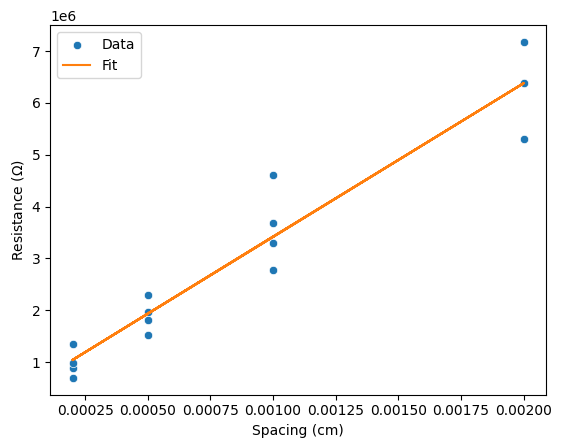

In [18]:
# 0G_37
# Potentiostat
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_37\AUT'
C_R(path)